**Charline Curaut : 3810013**

# PIMA : enhancement of vesselness filters in medical application

## Generals for both filters

Some useful libraries

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from scipy.ndimage.filters import convolve
import skimage.filters

Images and annotations loading

In [2]:
image109 = np.array(Image.open('images/images/109.jpg'))
annot109 = np.array(Image.open('images/annotations/109.jpg'))
test_img_109 = image109[:,:,0]
image108 = np.array(Image.open('images/images/108.jpg'))
annot108 = np.array(Image.open('images/annotations/108.jpg'))
test_img_108 = image108[:,:,0]

Some useful fonctions

In [3]:
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

def invert(image) :
    return 255 - image

def substract(image1, image2) :
    return image1 - image2

# 

## Hessian matrix : 
- application of a Gaussian kernel of standard deviation σ on the image.
- Computation of the directionnal derivate $I_x$ and $I_y$. Using the Sobel kernel.
- Computation of the double directionnal derivate $I_{xx}$, $I_{xy}$, $I_{yy}$.

In [4]:
def hessian_matrix_sobel2(image, scale) :
    """ Array[n, m]*float->Array[n*n, m*m]
        return the Hessian matrix from an image
    """
    gauss = gaussianKernel(scale)
    f = scipy.signal.convolve2d(image,gauss,mode='same')
    
    # derivative filter
    sobelY = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    sobelX = np.transpose(sobelY)
    
    # first derivatives calculation
    Ix = scipy.signal.convolve2d(f,sobelX,mode='same')
    Iy = scipy.signal.convolve2d(f,sobelY,mode='same')
    
    # second derivatives calculation
    Ixx = scipy.signal.convolve2d(Ix,sobelX,mode='same')
    Ixy = scipy.signal.convolve2d(Ix,sobelY,mode='same')
    Iyy = scipy.signal.convolve2d(Iy,sobelY,mode='same')
    
    return f, Ix, Iy, Ixx, Ixy, Iyy

In [5]:
def hessian_matrix_sobel(image,scale) :
    _, _, _, Ixx, Ixy, Iyy = hessian_matrix_sobel2(image, scale)
    return Ixx, Ixy, Iyy

Test Hessian

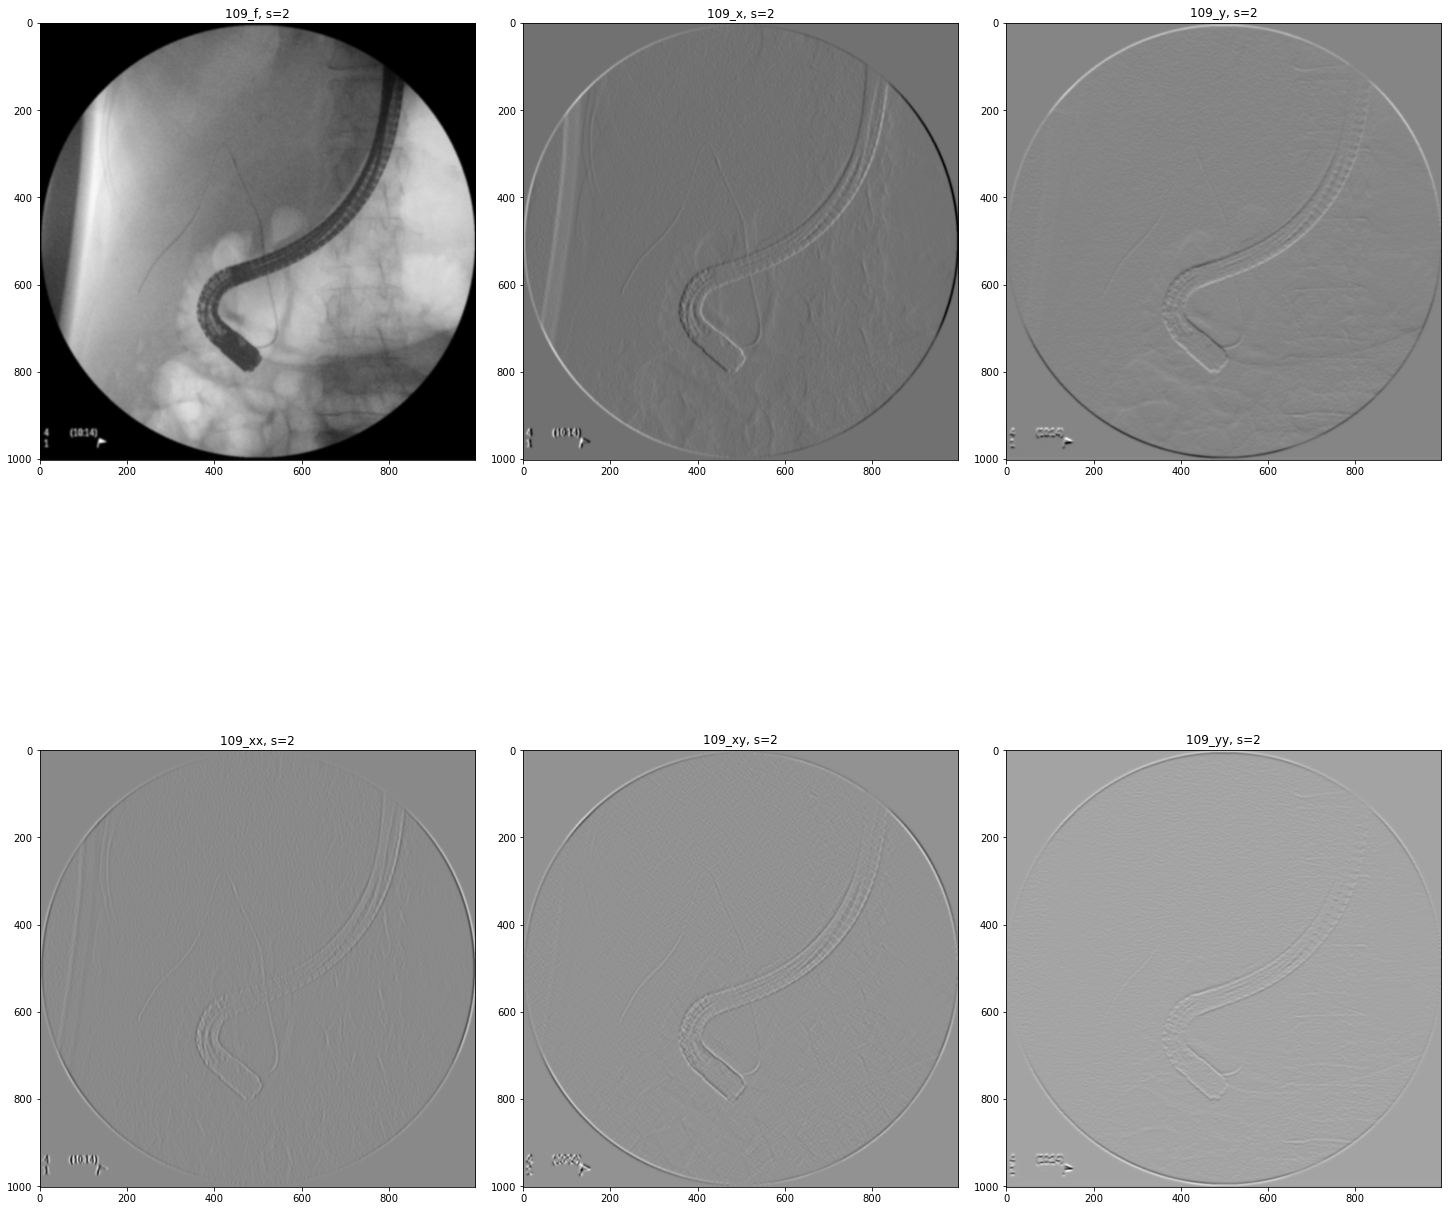

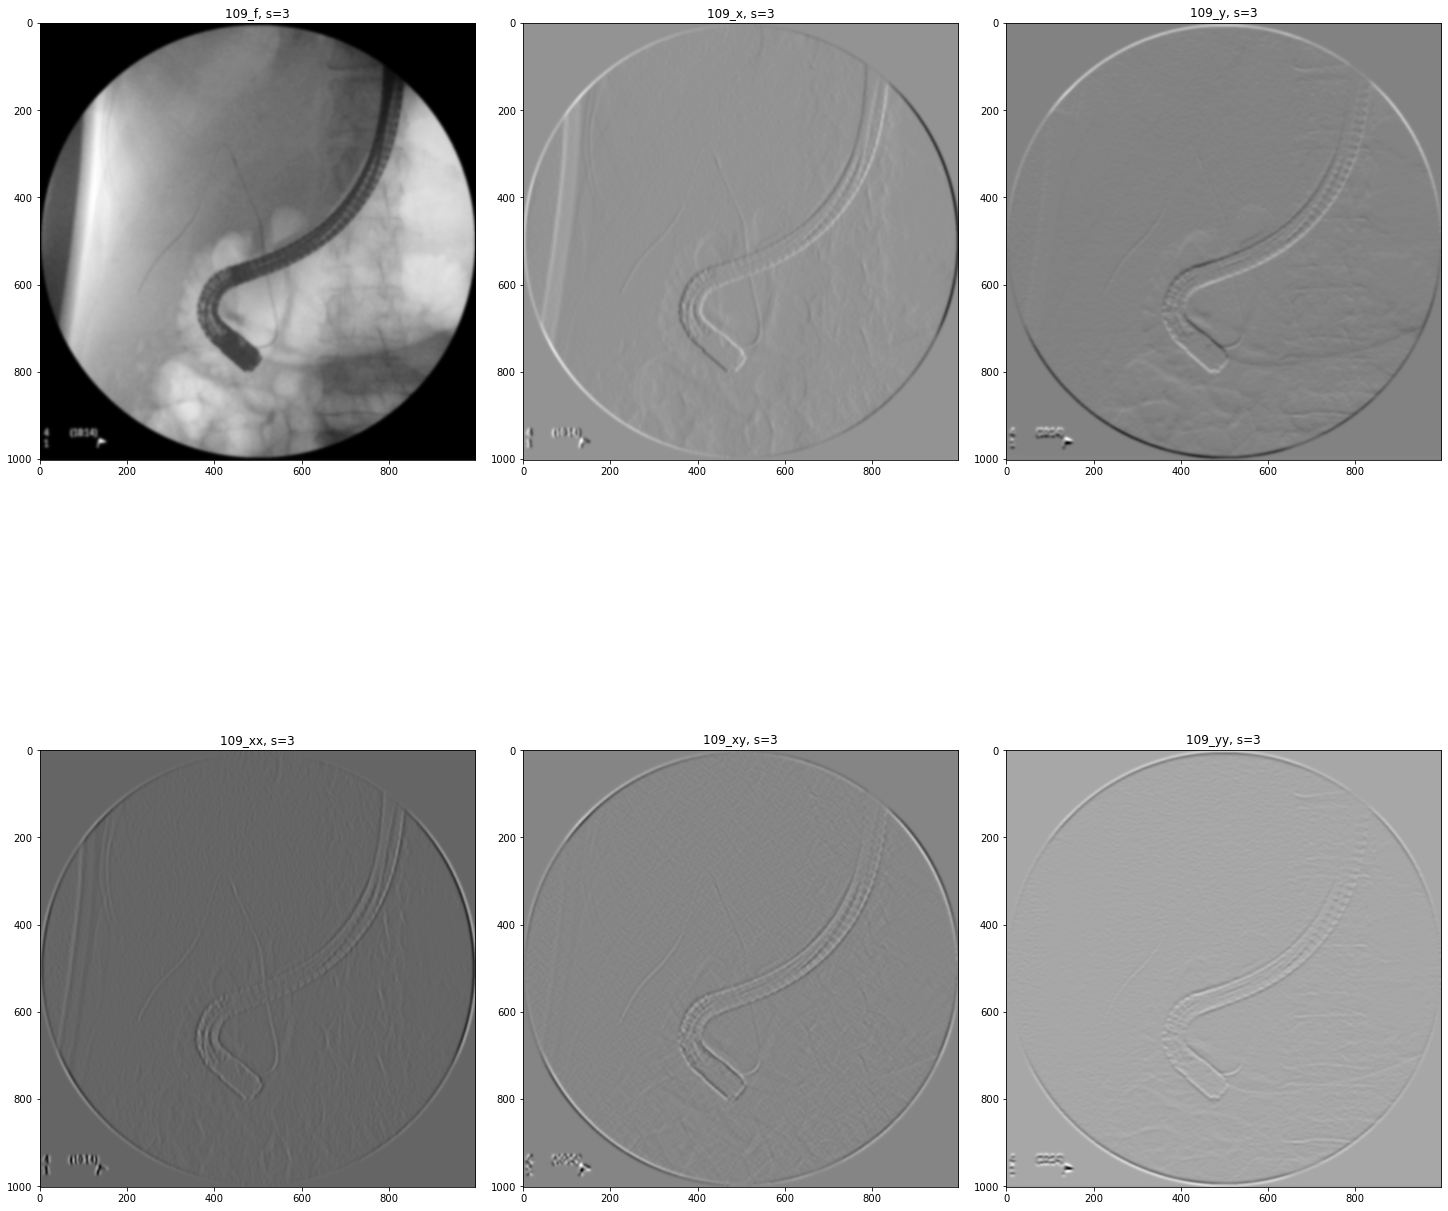

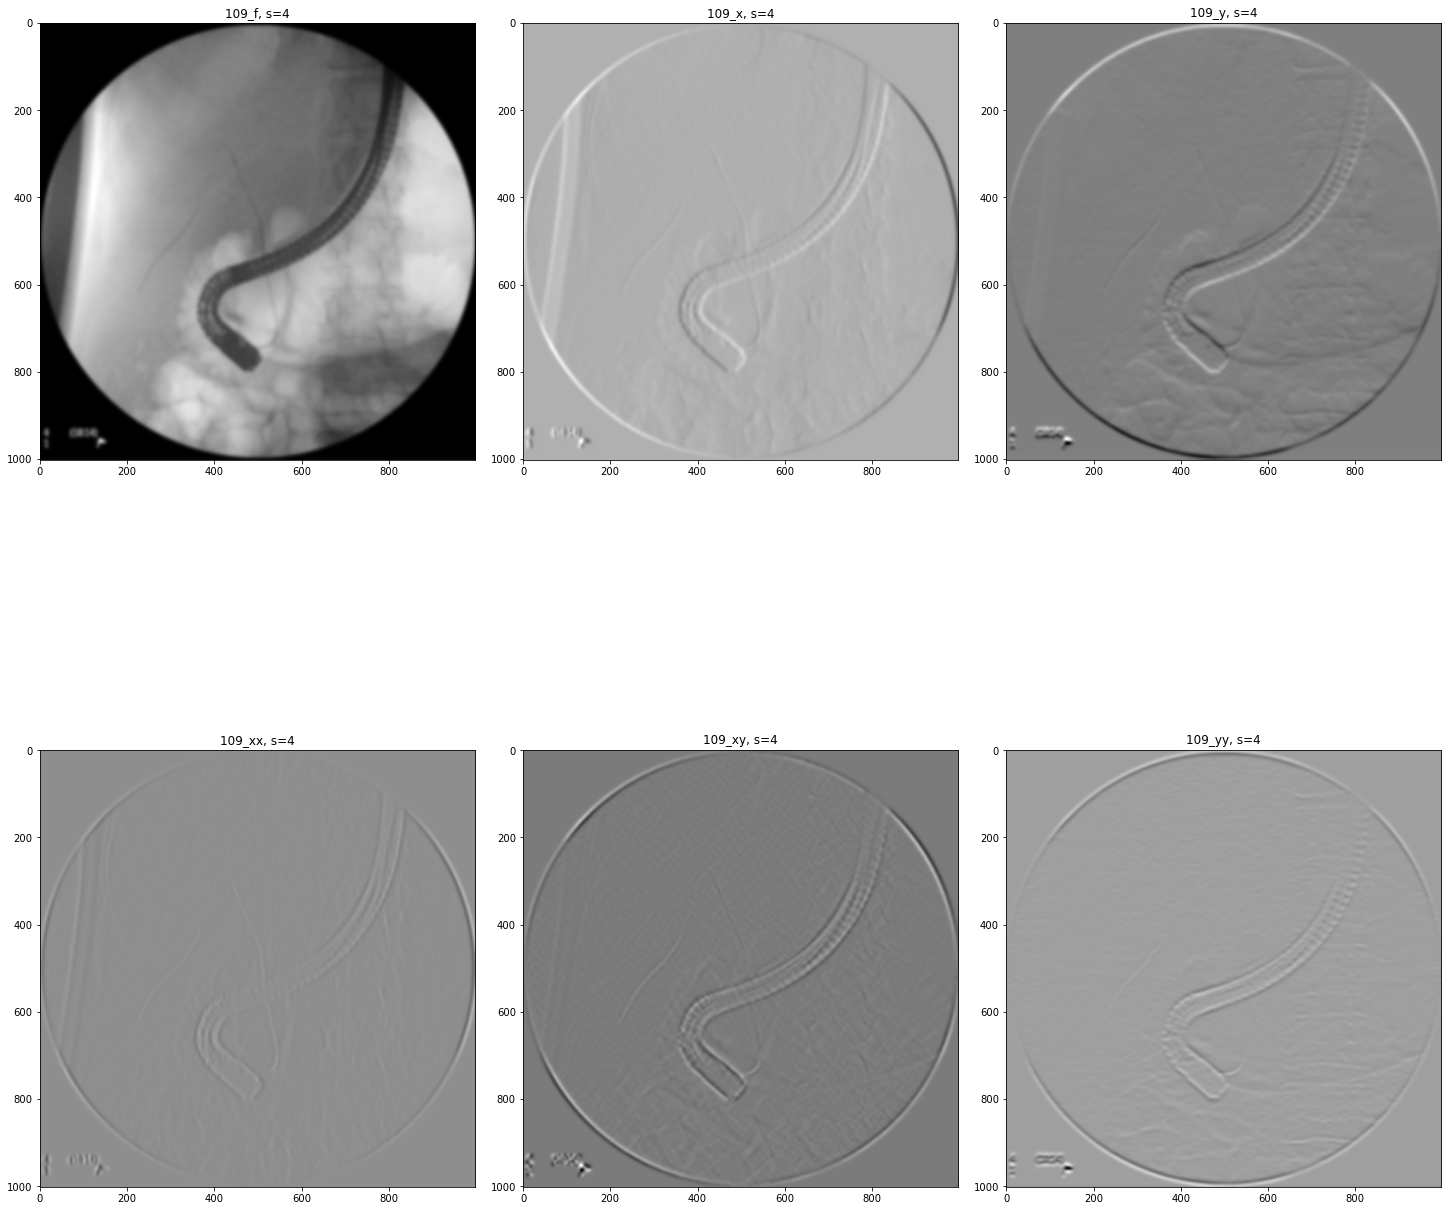

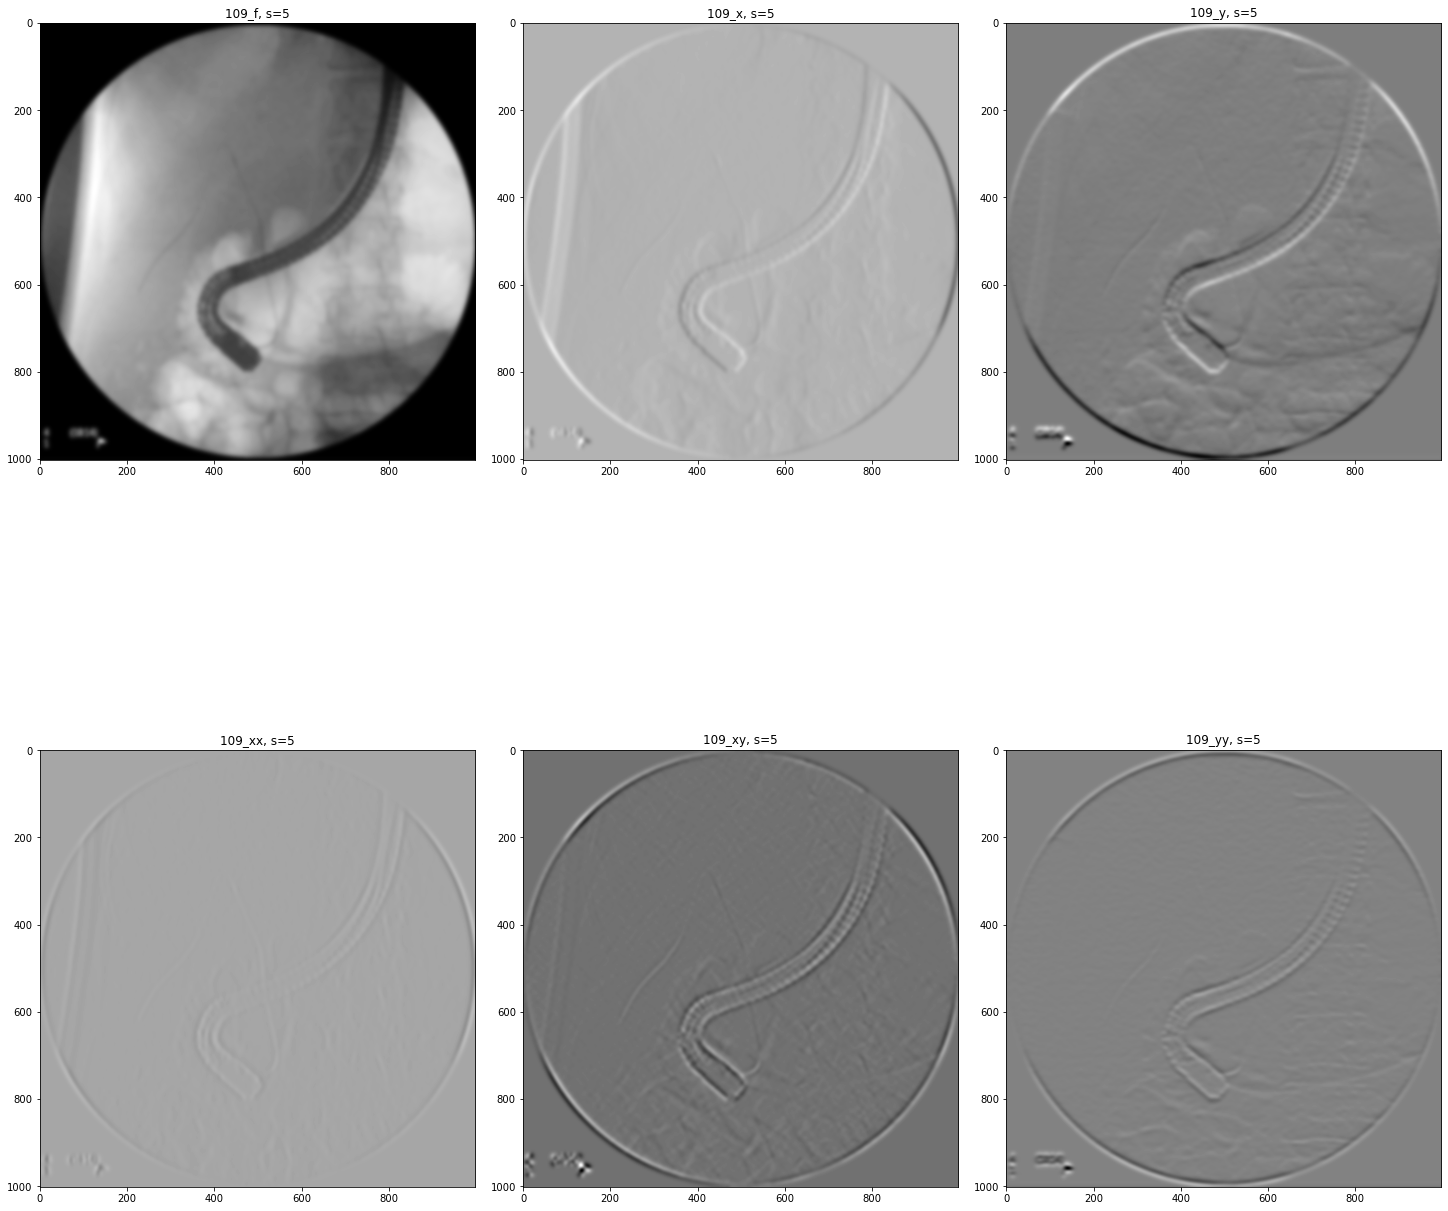

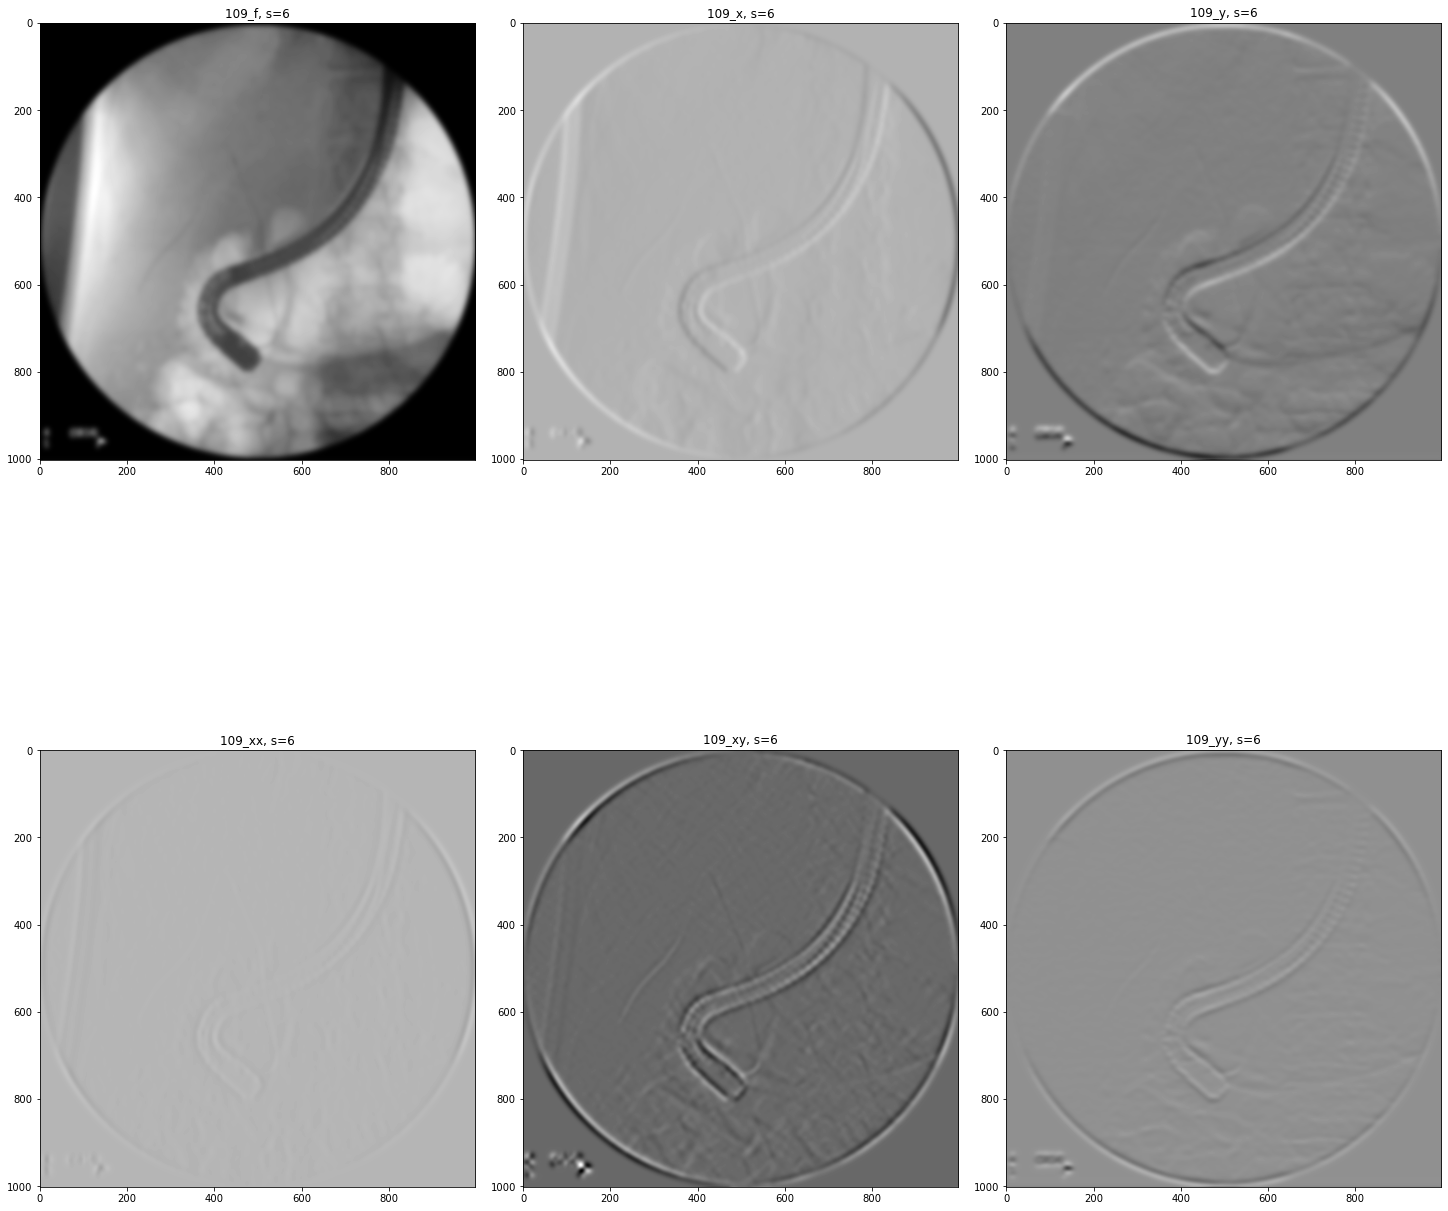

In [7]:
w,h=800,800

for i in range(2,7) :
    hessian_109_f, hessian_109_x, hessian_109_y, hessian_109_xx, hessian_109_xy, hessian_109_yy = hessian_matrix_sobel2(image109[:,:,0], i)
    
    axs = (plt.figure(constrained_layout=True,figsize=(w/40,h/40)).subplots(2, 3,sharex=False, sharey=False))
    
    axs[0][0].imshow(hessian_109_f,cmap="gray")
    axs[0][0].set_title("109_f, s="+str(i))

    axs[0][1].imshow(hessian_109_x,cmap="gray")
    axs[0][1].set_title("109_x, s="+str(i))

    axs[0][2].imshow(hessian_109_y,cmap="gray")
    axs[0][2].set_title("109_y, s="+ str(i))

    
    axs[1][0].imshow(hessian_109_xx,cmap="gray")
    axs[1][0].set_title("109_xx, s="+str(i))

    axs[1][1].imshow(hessian_109_xy,cmap="gray")
    axs[1][1].set_title("109_xy, s="+str(i))

    axs[1][2].imshow(hessian_109_yy,cmap="gray")
    axs[1][2].set_title("109_yy, s="+ str(i))

In [8]:
Ixx_109s, Ixy_109s, Iyy_109s = hessian_matrix_sobel(test_img_109, 3)
print("matrix Ixx :\n",Ixx_109s,"\n")
print("matrix Ixy :\n",Ixy_109s, "\n")
print("matrix Iyy :\n",Iyy_109s, "\n")

matrix Ixx :
 [[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 ...
 [ 13.32614076 -28.93900775  -5.56219876 ...  -5.56219876 -28.93900775
   13.32614076]
 [ 13.17037093 -28.60073844  -5.49718198 ...  -5.49718198 -28.60073844
   13.17037093]
 [  8.86733969 -19.25628858  -3.70113949 ...  -3.70113949 -19.25628858
    8.86733969]] 

matrix Ixy :
 [[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 ...
 [  4.08329997   3.39540676   1.87530505 ...  -1.87530505  -3.39540676
   -4.08329997]
 [ -5.16660779  -4.2962151   -2.37282731 ...   2.37282731   4.2962151
    5.16660779]
 [-24.75900298 -20.58797704 -11.37087249 ...  11.37

In [9]:
print(Ixx_109s.shape, Ixy_109s.shape, Iyy_109s.shape)

(1002, 998) (1002, 998) (1002, 998)


The results are a bit weird, the values in the end should be zero (or at least around zero) but they seem really high. That is strange because in this part of the image, there is nothing else that black : no particular structures so nothing to find by the derivative filters. 
Explanation after doing some research : Sobel Kernel = gaussian filter x derivative filter but we already applied a Gaussien filter, maybe it's to much. For the next attempt of hessian function, we will try to only use the derivative filter.

Trying another convolution to derivate the image :

In [6]:
def hessian_matrix_corrected(image, scale) :
    """ Array[n, m]*float->Array[n*n, m*m]
        return the Hessian matrix from an image
    """
    gauss = gaussianKernel(scale)
    f = scipy.signal.convolve2d(image,gauss,mode='same')
    
    # derivative filter
    Kx = np.array([[0, 0, 0],[1, 0, -1], [0, 0, 0]])
    Ky = Kx.T

    # first derivatives calculation
    Ix = scipy.signal.convolve2d(f,Kx,mode='same')
    Iy = scipy.signal.convolve2d(f,Ky,mode='same')
    
    # second derivatives calculation
    Ixx = scipy.signal.convolve2d(Ix,Kx,mode='same')
    Ixy = scipy.signal.convolve2d(Ix,Ky,mode='same')
    Iyy = scipy.signal.convolve2d(Iy,Ky,mode='same')
    
    return Ixx, Ixy, Iyy

another test to compare the new results :

In [120]:
Ixx_109c, Ixy_109c, Iyy_109c = hessian_matrix_corrected(test_img_109, 3)
print("matrix Ixx :\n",Ixx_109c, "\n")
print("matrix Ixy :\n",Ixy_109c, "\n")
print("matrix Iyy :\n",Iyy_109c,"\n")

matrix Ixx :
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.86638655 -1.88144246 -0.36162114 ... -0.36162114 -1.88144246
   0.86638655]
 [ 0.91128562 -1.97894515 -0.38036156 ... -0.38036156 -1.97894515
   0.91128562]
 [ 0.87116213 -1.8918131  -0.36361442 ... -0.36361442 -1.8918131
   0.87116213]] 

matrix Ixy :
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.47285953  0.15882314  0.12795966 ... -0.12795966 -0.15882314
  -0.47285953]
 [ 0.0142182   0.00477558  0.00384756 ... -0.00384756 -0.00477558
  -0.0142182 ]
 [-2.71314418 -0.91128562 -0.73419903 ...  0.73419903  0.91128562
   2.71314418]] 

matrix Iyy :
 [[ 0.          0.  

In [117]:
print(Ixx_109c.shape, Ixy_109c.shape, Iyy_109c.shape)

(1002, 998) (1002, 998) (1002, 998)


We obtained better results as they are much nearer from zero than the previous ones. But still, we may try a last solution to see if it can get any better.

In [7]:
def hessian_matrix_final(image, sigma) :
    """ Array[n, m]*float->Array[n*n, m*m]
        return the Hessian matrix from an image
    """
    
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    
    # we directly derivate the gaussian filter : less convolution so more effective
    exp_xy = np.exp(-((x**2 + y**2)/(2*sigma**2)))
    dGauss_xx = (1/(2*np.pi*sigma**4)) * ((x**2/(sigma**2)) - 1) * exp_xy
    dGauss_yy = (1/(2*np.pi*sigma**4)) * ((y**2/(sigma**2)) -1) * exp_xy
    dGauss_xy = ((x*y)/(2*np.pi*sigma**6)) * exp_xy
    
    Ixx = scipy.signal.convolve2d(image,dGauss_xx,mode='same')
    Iyy = scipy.signal.convolve2d(image,dGauss_yy,mode='same')
    Ixy = scipy.signal.convolve2d(image,dGauss_xy,mode='same')
    
    #Ixx = convolve(image, dGauss_xx, mode='constant', cval=0.0, origin=-1)
    #Ixy = convolve(image, dGauss_xy, mode='constant', cval=0.0, origin=-1)
    #Iyy = convolve(image, dGauss_yy, mode='constant', cval=0.0, origin=-1)
    
    return Ixx, Ixy, Iyy
    

In [119]:
Ixx_109f, Ixy_109f, Iyy_109f = hessian_matrix_final(test_img_109, 3)
print("matrix Ixx :\n",Ixx_109f, "\n")
print("matrix Ixy :\n",Ixy_109f, "\n")
print("matrix Iyy :\n",Iyy_109f,"\n")

matrix Ixx :
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.0308325  -0.0770384  -0.10148368 ... -0.10148368 -0.0770384
  -0.0308325 ]
 [-0.03243035 -0.08103079 -0.1067429  ... -0.1067429  -0.08103079
  -0.03243035]
 [-0.03100246 -0.07746304 -0.10204306 ... -0.10204306 -0.07746304
  -0.03100246]] 

matrix Ixy :
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.04711668  0.0420855   0.0335679  ... -0.0335679  -0.0420855
  -0.04711668]
 [ 0.00175603  0.00156852  0.00125107 ... -0.00125107 -0.00156852
  -0.00175603]
 [-0.04603225 -0.04111687 -0.03279531 ...  0.03279531  0.04111687
   0.04603225]] 

matrix Iyy :
 [[ 0.          0.   

In [121]:
print(Ixx_109f.shape, Ixy_109f.shape, Iyy_109f.shape)

(1002, 998) (1002, 998) (1002, 998)


The last values are still not equal to zero but none of them is greater than 1.0 (in absolute value).

##### NB : there are two convolution fonction define in the python packages : 
- scipy.ndimage.filters.convolve 
- scipy.signal.convolve2d 

After doing some research, we understand that the first one is faster to compute but the second one seems to respect more the strict definition of a convolution. For instance, the convolution of signal is commutative, whereas that of ndimage is not. And that is because the output depends on the fisrt argument given to the function.

# 

# Frangi & al.

### Computation of eigenvalues from a matrix :

In [18]:
def eigenvalues_frangi(image, scale) :
    """ Array[n, m]*float->Array[n,m,2]
        Compute the eigenvalues of the Hessian matrix of any pixel in an image and
        return a matrix containing those eigenvalues sorted by their absolute value
    """
    dim = image.shape
    # getting the Hessian matrix
    Ixx, Ixy, Iyy = hessian_matrix_final(image,scale)
    
    matrix = np.zeros((dim[0],dim[1],2))
    
    # computation of trace and determinant of the hessian matrix
    T = Ixx + Iyy
    D = Ixx*Iyy - Ixy**2
    
    # compute of the eigenvalues for each pixel
    # By the quadratic formula, we resolve the equation (det(H-lambda*I) = 0)
    tmp = np.sqrt((T**2 /4) - D)
    lambda1 = 0.5*T + tmp
    lambda2 = 0.5*T - tmp
    
    # sorted eigenvalues by their absolute values
    lambda1_sorted = np.where(np.abs(lambda1)<=np.abs(lambda2), lambda1, lambda2)
    lambda2_sorted = np.where(lambda1==lambda1_sorted, lambda2, lambda1)
    
    matrix[:,:,0] = lambda1_sorted
    matrix[:,:,1] = lambda2_sorted
    
    return matrix
    

### The measures from the eigenvalues of each pixel

In [19]:
def frangi_measures(image, scale, matrix_ev) :
    """ Array[n, m]*float->Array[n,m,2]
        return the measures needed for the Frangi filter
    """
    dim = image.shape
    matrix_m = np.zeros(matrix_ev.shape)
    
    for x in range(dim[0]) :
        for y in range(dim[1]) :
            # getting the eigenvalues of the pixel (i,j)
            y1 = matrix_ev[x,y,0]
            y2 = matrix_ev[x,y,1]
            # calculating the measures needed for this pixel
            if y2 == 0 :
                Rb = 0
            else : 
                Rb = y1 / y2
            S = np.sqrt(y1**2 + y2**2)
            # assigning those measures to a matrix
            matrix_m[x,y,0] = Rb
            matrix_m[x,y,1] = S
    
    return matrix_m

In [20]:
def frangi_measures2(image, scale) :
    """ Array[n, m]*float->Array[n,m,2]
        return the measures needed for the Frangi filter
    """
    dim = image.shape
    matrix_ev = eigenvalues_frangi(image,scale)
    return frangi_measures(image, scale, matrix_ev)

In [131]:
ev_109 = eigenvalues(test_img_109, 5)
fm_109 = frangi_measures(test_img_109,5,ev_109)
print(fm_109)

[[[0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]

 ...

 [[0.0866999  0.04737929]
  [0.21383321 0.0551015 ]
  [0.29478905 0.0626642 ]
  ...
  [0.29478905 0.0626642 ]
  [0.21383321 0.0551015 ]
  [0.0866999  0.04737929]]

 [[0.10089634 0.04915101]
  [0.22156104 0.05735036]
  [0.2962584  0.06535909]
  ...
  [0.2962584  0.06535909]
  [0.22156104 0.05735036]
  [0.10089634 0.04915101]]

 [[0.06900281 0.04764051]
  [0.19716744 0.05514154]
  [0.28084225 0.06248735]
  ...
  [0.28084225 0.06248735]
  [0.19716744 0.05514154]
  [0.06900281 0.04764051]]]


In [132]:
print(fm_109[:,:,1])
print(np.max(fm_109[:,:,1]))

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.04737929 0.0551015  0.0626642  ... 0.0626642  0.0551015  0.04737929]
 [0.04915101 0.05735036 0.06535909 ... 0.06535909 0.05735036 0.04915101]
 [0.04764051 0.05514154 0.06248735 ... 0.06248735 0.05514154 0.04764051]]
4.286875306868274


### The calculated fonction for each pixel

In [29]:
def frangi_function(image, scale, gamma, beta=0.5, black_ridges=True, choseGamma=False) :
    """ Array[n, m]*float*float*float*bool*bool->Array[n,m]
        return the value of the frangi fonction for each pixel
    """
    dim = image.shape
    matrix_ev = eigenvalues_frangi(image,scale)
    matrix_m = frangi_measures(image,scale, matrix_ev)
    
    if not choseGamma :
        # good estimation of gamma according to the article
        gamma = np.max(matrix_m)/2
    
    # initialisation
    matrix_f = np.zeros(dim)
    
    for x in range(dim[0]) :
        for y in range(dim[1]) :
            
            # In the dataset, all the guidewires to detect are dark on bright images
            # As specify in the 1998 Frangi article, we then inverse the conditions
            if (black_ridges) :
                if matrix_ev[x,y,1] <= 0 :
                    f = 0
                else :
                    e1 = np.exp( (-(matrix_m[x,y,0]**2)) / (2* (beta**2)) )
                    e2 = np.exp( (-(matrix_m[x,y,1]**2)) / (2* (gamma**2)) )
                    f = e1 * (1-e2)
                matrix_f[x,y] = f
            
            else :
                if matrix_ev[x,y,1] > 0 :
                    f = 0
                else :
                    e1 = np.exp( (-(matrix_m[x,y,0]**2)) / (2* (beta**2)) )
                    e2 = np.exp( (-(matrix_m[x,y,1]**2)) / (2* (gamma**2)) )
                    f = e1 * (1-e2)
                matrix_f[x,y] = f
            
    return matrix_f

### Calculation of the gamma parameter

In [34]:
def gamma(image,scale) :
    """ Array[n,m]*float->float
        return a correct value to give to the gamma parameter
    """
    matrix_m = frangi_measures2(image,scale)
    
    return np.max(matrix_m)/2

# 

# Jerman & al.

### Computing eigenvalues from a matrix

In [27]:
def eigenvalues_jerman(image, scale, black_ridges=True) :
    """ Array[n, m]*float*bool->Array[n,m,2]
        Compute the eigenvalues of the Hessian matrix of any pixel in an image and
        return a matrix containing those eigenvalues sorted by their absolute value
    """
    
    if not black_ridges :
        return -eigenvalues_frangi(image,scale)
    else :
        return eigenvalues_frangi(image, scale)

### Computing lambda_p

In [45]:
def lambda_p2(image, scale, tau, matrix_ev, black_ridges=True) :
    """ Array[n, m]*float*float*bool->Array[n,m]
        Compute the lambda_p parameter that replace lambda3 in 3D
    """
    matrix_ev = eigenvalues_jerman(image, scale, black_ridges)
    
    # In 2D, we assume lambda3 = lambda2 (lambda3 is a third eigenvalue for 3D)
    lambda3 = matrix_ev[:,:,1]
    
    # computation of lambda_p
    max_l3 = np.max(lambda3)
    #lambda_p = np.where(lambda3>tau*max_l3, lambda3, (np.where(lambda3<=0,0,tau*max_l3)))
    
    lambda_p_tmp = np.where(lambda3>tau*max_l3, lambda3, tau*max_l3)
    lambda_p = np.where(lambda3<=0, 0, lambda_p_tmp)
    
    return lambda_p

In [51]:
def lambda_p(image, scale, tau, black_ridges=True) :
    """ Array[n, m]*float*float*bool->Array[n,m]
        Compute the lambda_p parameter that replace lambda3 in 3D
    """
    matrix_ev = eigenvalues_jerman(image, scale, black_ridges)
    
    return lambda_p2(image, scale, tau, matrix_ev, black_ridges)

### The calculated function for each pixel

In [49]:
def jerman_function(image, scale, tau, black_ridges=True) :
    """ Array[n, m]*float*float*bool->Array[n,m]
        return the value of the frangi fonction for each pixel
    """
    
    # initialisation
    matrix_ev = eigenvalues_jerman(image, scale, black_ridges)
    lambda2 = matrix_ev[:,:,1]
    l_p = lambda_p(image, scale, tau, black_ridges)
    
    
    #####
    ##### Note à moi-même : trouver une autre façon de le faire : il faut faire le gros calcul en dernier !
    ##### si possible sans faire pixel par pixel (long)
    #####
    matrix_tmp = lambda2**2 * (l_p - lambda2) * (3/(lambda2+l_p))**3
    
    matrix_tmp2 = np.where(((l_p<=0) | (lambda2<=0)), 0, matrix_tmp)
    
    matrix_f = np.where(((lambda2>=0.5*l_p) & (0.5*l_p > 0)), 1, matrix_tmp2)
    
    return matrix_f
    

# 

# The test and experimental part

## General Tests

#### Plots of images and kernel tests

Text(0.5, 1.0, 'filtre gaussien, sigma=1')

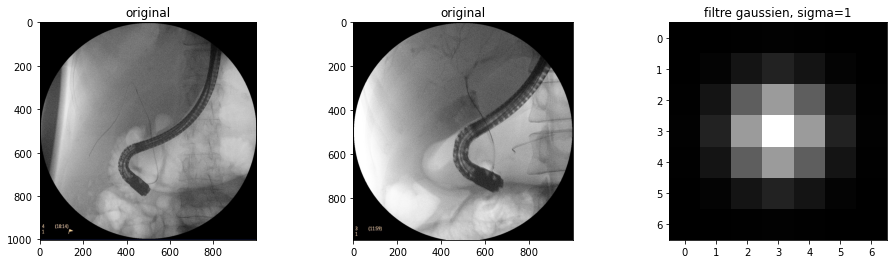

In [150]:
gauss = gaussianKernel(1)

fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 3, 1)
ax.imshow(image109,cmap="gray")
ax.set_title("original")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(image108,cmap="gray")
ax.set_title("original")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(gauss,cmap="gray")
ax.set_title("filtre gaussien, sigma=1")

Text(0.5, 1.0, 'gaussian filter on pixels 2')

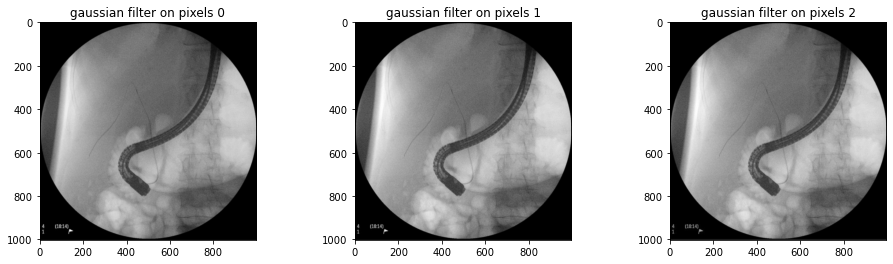

In [14]:
f0 = scipy.signal.convolve2d(image109[:,:,0],gauss,mode='same')
f1 = scipy.signal.convolve2d(image109[:,:,1],gauss,mode='same')
f2 = scipy.signal.convolve2d(image109[:,:,2],gauss,mode='same')

fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 3, 1)
ax.imshow(f0,cmap="gray")
ax.set_title("gaussian filter on pixels 0")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(f1,cmap="gray")
ax.set_title("gaussian filter on pixels 1")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(f2,cmap="gray")
ax.set_title("gaussian filter on pixels 2")

## Frangi tests

#### eigenvalues 
compared to another code found on github, correct (changing the fonction hessian_matrix by mine, we can compare the results and they are the same)

In [12]:
def eig2image(image, scale):
    """
    This function eig2image calculates the eigen values from the
    hessian matrix, sorted by abs value. And gives the direction
    of the ridge (eigenvector smallest eigenvalue) .
    | Dxx  Dxy |
    | Dxy  Dyy |
    """
    ### Test pour la matrice hessienne
    # lambda1, lambda2
    #Dxx, Dxy, Dyy = hessian_matrix_sobel(image,scale)
    # lambda1bis, lambda2bis
    #Dxx, Dxy, Dyy = hessian_matrix_corrected(image,scale)
    # lambda1ter, lambda2ter
    Dxx, Dxy, Dyy = hessian_matrix_final(image,scale)
    
    # Compute the eigenvectors of J, v1 and v2
    tmp = np.sqrt((Dxx - Dyy)**2 + 4*Dxy**2)
    v2x = 2*Dxy
    v2y = Dyy - Dxx + tmp

    # Normalize
    mag = np.sqrt(v2x**2 + v2y**2)
    i = np.invert(np.isclose(mag, np.zeros(mag.shape)))
    v2x[i] = v2x[i]/mag[i]
    v2y[i] = v2y[i]/mag[i]

    # The eigenvectors are orthogonal
    v1x = -v2y.copy()
    v1y = v2x.copy()

    # Compute the eigenvalues
    mu1 = 0.5*(Dxx + Dyy + tmp)
    mu2 = 0.5*(Dxx + Dyy - tmp)

    # Sort eigenvalues by absolute value abs(Lambda1)<abs(Lambda2)
    check = np.absolute(mu1) > np.absolute(mu2)

    Lambda1 = mu1.copy()
    Lambda1[check] = mu2[check]
    Lambda2 = mu2.copy()
    Lambda2[check] = mu1[check]

    Ix = v1x.copy()
    Ix[check] = v2x[check]
    Iy = v1y.copy()
    Iy[check] = v2y[check]

    return Lambda1, Lambda2, Ix, Iy

The two functions give the same results : it works !

In [13]:
eig_m = eigenvalues_frangi(test_img_109, 5)

lambda1, lambda2, _, _ = eig2image(test_img_109,5)

eig_m2 = np.zeros((lambda1.shape[0], lambda1.shape[1], 2))
eig_m2[:,:,0] = lambda1
eig_m2[:,:,1] = lambda2

print(eig_m)
print(eig_m2)

print(np.allclose(eig_m, eig_m2))

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ...

 [[-0.00409243 -0.04720221]
  [-0.01152205 -0.05388337]
  [-0.01771887 -0.06010694]
  ...
  [-0.01771887 -0.06010694]
  [-0.01152205 -0.05388337]
  [-0.00409243 -0.04720221]]

 [[-0.00493411 -0.04890273]
  [-0.01240576 -0.05599251]
  [-0.01856557 -0.06266682]
  ...
  [-0.01856557 -0.06266682]
  [-0.01240576 -0.05599251]
  [-0.00493411 -0.04890273]]

 [[-0.00327953 -0.0475275 ]
  [-0.01066676 -0.0541    ]
  [-0.01689544 -0.06015989]
  ...
  [-0.01689544 -0.060159

#### gamma function tests with different image and different scale

In [160]:
gamma_109_5 = gamma(test_img_109, 5)
print(gamma_109_5)
gamma_108_5 = gamma(test_img_108, 5)
print(gamma_108_5)

2.143437653434137
1.3016604505580482


In [159]:
gamma_109_3 = gamma(test_img_109, 3)
print(gamma_109_3)
gamma_108_3 = gamma(test_img_108, 3)
print(gamma_108_3)

5.8516811932110935
4.1431389548406585


#### frangi_function test with two different images (and the previous calculated gamma)

In [177]:
filtered_img109 = frangi_function(test_img_109,3,gamma_109_3)

Text(0.5, 1.0, 'annotation')

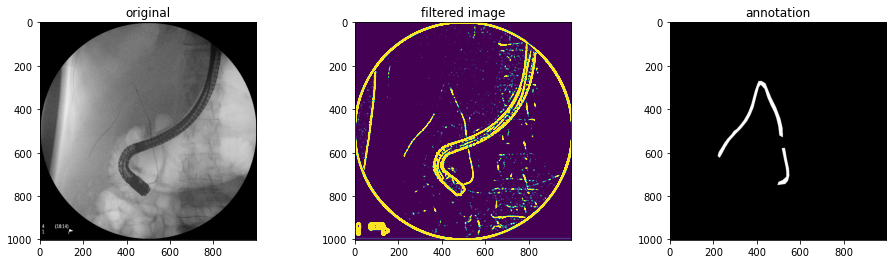

In [189]:
fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 3, 1)
ax.imshow(test_img_109,cmap="gray")
ax.set_title("original")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(filtered_img109, vmin=0, vmax=0.001)
ax.set_title("filtered image")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(annot109,cmap="gray")
ax.set_title("annotation")

In [193]:
filtered_img108 = frangi_function(test_img_108,3,gamma_108_3)

Text(0.5, 1.0, 'annotation')

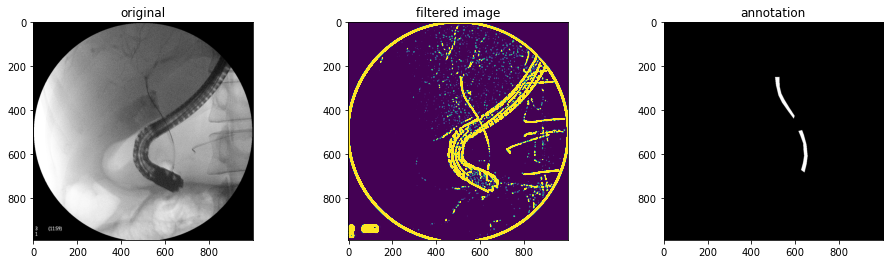

In [194]:
fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 3, 1)
ax.imshow(test_img_108,cmap="gray")
ax.set_title("original")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(filtered_img108, vmin=0, vmax=0.001)
ax.set_title("filtered image")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(annot108,cmap="gray")
ax.set_title("annotation")

#### comparaison of the results between my functions for frangi and skimage frangi filter

Text(0.5, 1.0, 'filtered image with library')

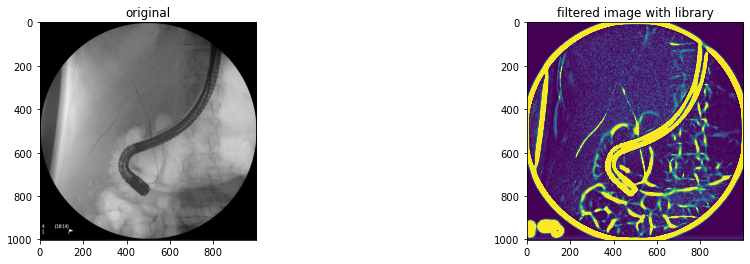

In [192]:
fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 2, 1)
ax.imshow(test_img_109,cmap="gray")
ax.set_title("original")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(skimage.filters.frangi(test_img_109), vmin=0, vmax=1.e-6)
ax.set_title("filtered image with library")

Text(0.5, 1.0, 'filtered image with library')

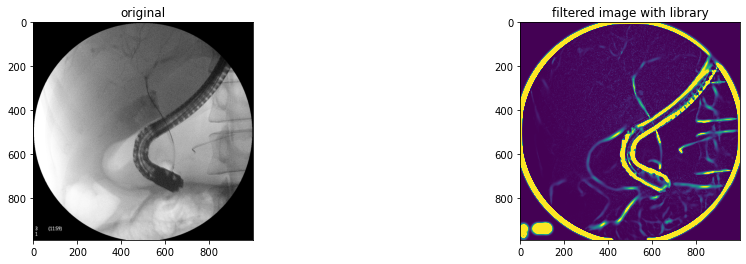

In [199]:
fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 2, 1)
ax.imshow(test_img_108,cmap="gray")
ax.set_title("original")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(skimage.filters.frangi(test_img_108), vmin=0, vmax=5.e-6)
ax.set_title("filtered image with library")

# 

## Jerman tests

In [52]:
filtered_img109_jerman = jerman_function(test_img_109, 3, 0.5)

<ipython-input-49-76b341701c18>:12: RuntimeWarning: divide by zero encountered in true_divide
  matrix_tmp = lambda2**2 * (l_p - lambda2) * (3/(lambda2+l_p))**3
<ipython-input-49-76b341701c18>:12: RuntimeWarning: invalid value encountered in multiply
  matrix_tmp = lambda2**2 * (l_p - lambda2) * (3/(lambda2+l_p))**3


Text(0.5, 1.0, 'annotation')

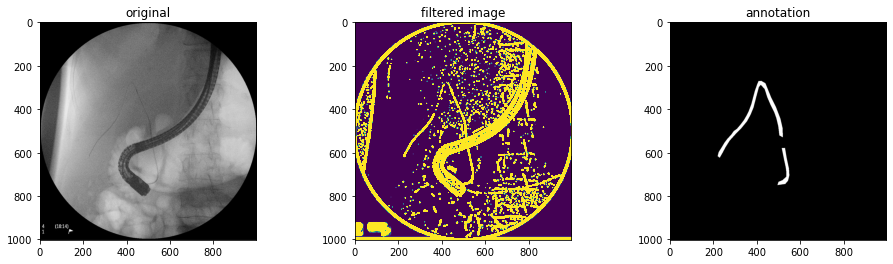

In [53]:
fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 3, 1)
ax.imshow(test_img_109,cmap="gray")
ax.set_title("original")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(filtered_img109_jerman, vmin=0, vmax=0.001)
ax.set_title("filtered image")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(annot109,cmap="gray")
ax.set_title("annotation")

## Pour Garance

Check quality of eigenvalues (lambda1 near zero and lambda2 higher than lambda1 in absolute value)

Text(0.5, 1.0, 'annotation')

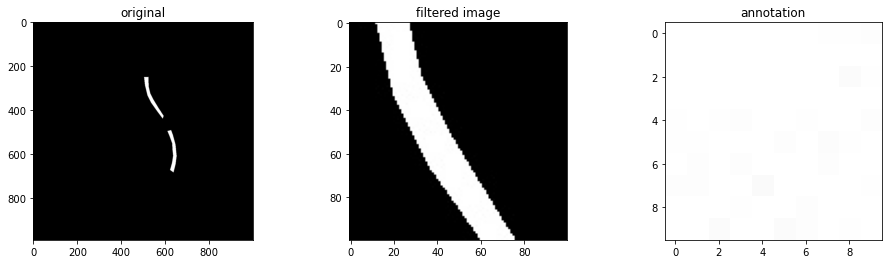

In [63]:
fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 3, 1)
ax.imshow(annot108,cmap="gray")
ax.set_title("original")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(annot108[300:400, 500:600], vmin=0, vmax=0.001)
ax.set_title("filtered image")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(annot108[340:350, 530:540],cmap="gray")
ax.set_title("annotation")

In [65]:
### with hessian_matrix_sobel()
lambda1, lambda2, _, _ = eig2image(test_img_109[340:350,530:540],5)
print("lambda1 :\n", lambda1, "\n")
print("lambda2 :\n", lambda2, "\n")

lambda1 :
 [[-227.40762821  191.28786142  -66.33790556  -52.19307356  -42.75614157
   -42.90420772  -52.61016149  -66.95838692  190.27864972 -227.3297666 ]
 [ 130.93003357 -343.75443846  -48.40883428  -59.14762479  -64.83525669
   -64.75521465  -58.91949609  -48.06634959 -342.96817484  131.05387389]
 [ -44.46622221  -47.8312436   -45.85289804  -56.35048869  -61.88841239
   -61.43281332  -55.3710042   -44.82082935  -47.98318123  -44.12776316]
 [ -43.01474111  -58.97489748  -56.76113166  -68.09504809  -73.98550327
   -73.20676962  -66.72872184  -55.41579237  -58.86459067  -42.64901025]
 [ -42.01335784  -65.13503049  -62.80493759  -74.51121332  -80.77686143
   -79.52865163  -73.24100024  -61.49906977  -64.7506328   -41.63854003]
 [ -42.02122056  -65.52421955  -62.85936312  -74.26467715  -80.08246486
   -80.76319355  -74.00721118  -61.93303471  -64.88770066  -41.61216364]
 [ -43.07220169  -60.08039093  -57.17135904  -68.2233747   -74.32754016
   -74.59730492  -68.14251375  -56.38762534  -5

In [67]:
### with hessia_matrix_corrected
lambda1bis, lambda2bis, _, _ = eig2image(test_img_109[340:350,530:540],5)
print("lambda1 :\n", lambda1bis, "\n")
print("lambda2 :\n", lambda2bis, "\n")

lambda1 :
 [[-27.31874773   7.96264988  -5.05057986  -4.37817476  -3.93003462
   -3.93958541  -4.40540523  -5.09163128   7.87557742 -27.29338993]
 [  7.8880381  -26.79170073  -3.31542127  -3.9617168   -4.30328887
   -4.29958731  -3.95100447  -3.29884664 -26.71945791   7.87741121]
 [ -5.16506093  -3.28360694  -2.87955234  -3.55678743  -3.92084551
   -3.89008617  -3.49266425  -2.81347017  -3.29319253  -5.08593613]
 [ -4.47540748  -3.95590857  -3.5818229   -4.30525608  -4.68801987
   -4.63587529  -4.21659268  -3.49545699  -3.94730621  -4.40258048]
 [ -3.99264521  -4.3267312   -3.97830979  -4.72080227  -5.1194699
   -5.03784936  -4.63805071  -3.89429394  -4.29927034  -3.93948779]
 [ -3.96823351  -4.35132566  -3.98170692  -4.70405541  -5.07359906
   -5.11862062  -4.68941742  -3.92366502  -4.30680237  -3.93266204]
 [ -4.42161544  -4.02587216  -3.60853878  -4.31290425  -4.70790664
   -4.72621952  -4.30829975  -3.55916271  -3.96832421  -4.38417706]
 [ -5.11820525  -3.38830496  -2.94194212  -3.

In [69]:
### with hessia_matrix_final
lambda1ter, lambda2ter, _, _ = eig2image(test_img_109[340:350,530:540],5)
print("lambda1 :\n", lambda1ter, "\n")
print("lambda2 :\n", lambda2ter, "\n")

lambda1 :
 [[ 0.10800588 -0.07261428 -0.23760175 -0.36477205 -0.43387004 -0.43220404
  -0.36111192 -0.23442631 -0.07154555  0.10661278]
 [-0.07598189 -0.29845919 -0.49874191 -0.65186005 -0.7342685  -0.73015652
  -0.64254172 -0.48902848 -0.29107477 -0.07168375]
 [-0.24570485 -0.50373309 -0.73279203 -0.9062072  -0.99855262 -0.99084236
  -0.88993752 -0.71596021 -0.48955135 -0.23496954]
 [-0.37882348 -0.66338828 -0.91289797 -1.09944096 -1.19722045 -1.18400749
  -1.07667136 -0.89071534 -0.64366887 -0.36205976]
 [-0.45454521 -0.75359269 -1.0137006  -1.20592015 -1.30892694 -1.28797852
  -1.18462758 -0.9920167  -0.73145598 -0.43321708]
 [-0.45883778 -0.75699228 -1.0146668  -1.2017386  -1.29726498 -1.30872126
  -1.19764144 -0.99936023 -0.73517422 -0.43458299]
 [-0.3914484  -0.67443628 -0.91997591 -1.10166255 -1.20279481 -1.20740251
  -1.10029586 -0.90688816 -0.65245457 -0.3652    ]
 [-0.26550503 -0.52279203 -0.74921646 -0.92049328 -1.01606223 -1.01553604
  -0.91435781 -0.73378631 -0.49938169 -0

### Note : Pour Sobel, l'écart entre les valeurs propres 1 et 2 est plus grand (ce qui est ce qu'on cherche) mais les valeurs de lambda1 sont très grandes (il est sensé être autour de 0). Pour le deuxième (avec un filtre dérivative simple), l'écart est moins grand (c'est bof) mais lambda1 est plus petit (c'est mieux). Pour le troisième, l'écart est quasiment nul (ce n'est pas du tout ce qu'on cherche) mais lambda1 est proche de 0.